In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import random
import seaborn as sns
from scipy.optimize import minimize
import datetime
from xgboost import XGBRegressor, plot_importance
import cvxpy as cp
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import sys

In [71]:
START_DATE = '2006-1-1'
END_DATE = datetime.datetime.today().strftime('%Y-%m-%d') # today's date
TRAINING_START_DATE = START_DATE
TRAINING_END_DATE = '2022-1-1'
OUT_OF_SAMPLE_START_DATE = '2023-1-1'

In [72]:
# get top 70 companies ticker 
# Download S&P 500 company tickers
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
tickers = df['Symbol'].tolist()

In [73]:

num_assests = 5
removed_assests = 0
assests = tickers[:num_assests]
error_assests = ['BRK.B','ANET','ABBV']
for ea in error_assests:
    if ea in assests:
        assests.remove(ea)
        assests.append(tickers[num_assests+removed_assests])
        removed_assests += 1

DYahoo = yf.download(" ".join(assests), start=START_DATE,end=END_DATE)

[*********************100%%**********************]  5 of 5 completed


In [74]:
DYahoo = DYahoo.fillna(method='ffill')
assert DYahoo.isna().sum().sum() == 0

C:\Users\saran\AppData\Local\Temp\ipykernel_1788\3086565185.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  DYahoo = DYahoo.fillna(method='ffill')


In [75]:
DYahoo = DYahoo.drop('Close',axis=1)
DYahoo = DYahoo.drop('High', axis=1)
DYahoo = DYahoo.drop('Low',axis=1)
DYahoo = DYahoo.drop('Open',axis=1)
DYahoo = DYahoo.drop('Volume',axis=1)
#DYahoo.index = pd.to_datetime(DYahoo.index).to_period('D')

In [76]:
df = DYahoo.copy()

Helping data being used 
- Fama-French indicators
- Oil-Index
- Nasdaq composite


https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [77]:
famaFrench = pd.read_csv("./FamaFrench5.CSV")
famaFrench.index = famaFrench.index.map(lambda x: str(x))
famaFrench.index = famaFrench.index.map(mapper = lambda x: pd.to_datetime(f"{x[:4]}{x[4:6]}{x[6:]}"))
famaData = famaFrench[(famaFrench.index >= START_DATE) & (famaFrench.index <= END_DATE)]
famaData.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
2006-01-03,1.50,-0.15,0.16,0.18,-0.32,0.017
2006-01-04,0.46,0.31,0.03,-0.45,0.33,0.017
2006-01-05,0.03,0.23,-0.10,-0.55,0.20,0.017
2006-01-06,0.92,0.10,-0.24,-0.04,0.14,0.017
2006-01-09,0.45,0.51,-0.17,0.06,-0.03,0.017


In [78]:
x_data = famaData[famaData.index <= END_DATE]

### Using Oil Price Data

In [79]:
# add other indicators
wti_oil = yf.Ticker("WTI")
oil_data = wti_oil.history(start=START_DATE, end=END_DATE)
# oil_data contains columns: Open	High Low	Close	Volume	Dividends	Stock Splits
oil_data = oil_data.rename(columns={'Close':'Oil_Index_Price'})
oil_data.index = oil_data.index.map(mapper = lambda x: pd.to_datetime(f"{x.year}-{x.month}-{x.day}"))
assert oil_data.isna().sum().sum() == 0
oil_data = oil_data[(oil_data.index <= x_data.index[-1]) & (oil_data.index >= x_data.index[0])] 
# applying log normalisation due to high variance
x_data['Oil_Index'] = np.log(oil_data['Oil_Index_Price'].values)
x_data['Oil_price_change'] = oil_data['Oil_Index_Price'].values-oil_data['Open'].values

### Using the Nasdaq price data

In [80]:
nasdaq_composite = yf.Ticker("^IXIC").history(start=START_DATE,end=END_DATE)
nasdaq_composite = nasdaq_composite.rename(columns={'Close':'TNX_Price'})
nasdaq_composite.index = nasdaq_composite.index.map(mapper = lambda x: pd.to_datetime(f"{x.year}-{x.month}-{x.day}"))
assert nasdaq_composite.isna().sum().sum() == 0
nasdaq_composite = nasdaq_composite[(nasdaq_composite.index <= x_data.index[-1])]
assert nasdaq_composite.shape[0] == x_data.shape[0]
# applying log normalisation due to high variance
x_data['Nasdaq Price'] = np.log(nasdaq_composite['TNX_Price'].values)
x_data['Nasdaq_price_change'] = nasdaq_composite['TNX_Price'].values - nasdaq_composite['Open'].values

In [81]:
df = df.loc[x_data.index]
assert df.shape[0] == x_data.shape[0]
y_data = df.copy()

In [82]:
# components = 2 # components < helpful data variables
# pca = PCA(n_components=components)
# copied_X = x_data.copy()
# standard_scaler = preprocessing.StandardScaler()
# copied_X = standard_scaler.fit_transform(copied_X)
# principal_components = pca.fit_transform(copied_X)
# print(pca.explained_variance_)
# xhat_data = pd.DataFrame(data=principal_components,index=x_data.index,columns=[f"feature {i}" for i in range(1,components+1)])

### Shape checks and changing axis level for y_data

In [83]:
xhat_data = x_data.copy()
assert xhat_data.shape[0] == y_data.shape[0]
y_data = df.copy()
assert y_data.shape[0] == x_data.shape[0]
y_data = y_data.droplevel(0,axis=1)

### Potential additional helpful features

In [84]:
# rolling_time_period = 5 # calculate weekly rolling statistics
# rolling_nasdaq_correlation = y_data.rolling(rolling_time_period).corr(nasdaq_composite['Volume'])
# rolling_nasdaq_correlation.columns = [f"{col}_PVRNasdaq" for col in y_data.columns]
# rolling_nasdaq_correlation.index.name = 'Date'
# rolling_oil_correlation = y_data.rolling(rolling_time_period).corr(oil_data['Volume'])
# rolling_oil_correlation.columns=[f"{col}_PVROil" for col in y_data.columns]
# rolling_oil_correlation.index.name = 'Date'
# rolling_mean_nasdaq = xhat_data['Nasdaq_price_change'].rolling(window=rolling_time_period).mean()
# rolling_mean_nasdaq.name = 'rolling_nasdaq'
# rolling_mean_nasdaq.index.name = 'Date'
# rolling_mean_oil = xhat_data['Oil_Index'].rolling(window=rolling_time_period).mean()
# rolling_mean_oil.index.name = 'Date'
# rolling_mean_oil.name = 'rolling_oil'
# added_indicators_df = rolling_oil_correlation.join([rolling_mean_nasdaq,rolling_mean_oil,rolling_nasdaq_correlation])

### Normalizing price data

In [85]:
price_data = y_data.copy() # data in terms of dollars
y_data = y_data.pct_change().dropna() # data in terms of returns
scaler = preprocessing.StandardScaler()

y_train = y_data[(y_data.index >= TRAINING_START_DATE) & (y_data.index <= TRAINING_END_DATE)]
y_test = y_data[(y_data.index > TRAINING_END_DATE) & (y_data.index < OUT_OF_SAMPLE_START_DATE)]
out_of_sample_y = y_data[y_data.index >= OUT_OF_SAMPLE_START_DATE]

In [86]:
y_train = pd.DataFrame(scaler.fit_transform(y_train),columns=y_train.columns,index=y_train.index)
y_test = pd.DataFrame(scaler.transform(y_test),columns=y_test.columns,index=y_test.index)

In [87]:
X_helpful_data = xhat_data.copy()
X_helpful_data.index.name = 'Date'

### All the features being used as helpful data

In [88]:
X_helpful_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF,Oil_Index,Oil_price_change,Nasdaq Price,Nasdaq_price_change
Date,,,,,,,,,,
2006-01-03,1.50,-0.15,0.16,0.18,-0.32,0.017,3.126442,0.645644,7.715899,27.209961
2006-01-04,0.46,0.31,0.03,-0.45,0.33,0.017,3.130387,0.060060,7.724650,16.500000
2006-01-05,0.03,0.23,-0.10,-0.55,0.20,0.017,3.144072,0.307807,7.730557,11.940186
2006-01-06,0.92,0.10,-0.24,-0.04,0.14,0.017,3.159168,0.285285,7.743105,16.410156
2006-01-09,0.45,0.51,-0.17,0.06,-0.03,0.017,3.139531,-0.480479,7.748758,12.510010


### Defining training and testing data and shape checks before training

In [89]:
X_train = X_helpful_data[(X_helpful_data.index >= y_train.index[0]) & (X_helpful_data.index <= y_train.index[-1])]
X_test = X_helpful_data[(X_helpful_data.index > y_train.index[-1]) & (X_helpful_data.index < OUT_OF_SAMPLE_START_DATE)]
out_of_sample_X = X_helpful_data[X_helpful_data.index >= OUT_OF_SAMPLE_START_DATE]
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]
assert y_train.shape[0] == X_train.shape[0]
assert y_test.shape[0] == y_test.shape[0]
assert out_of_sample_y.shape[0] == out_of_sample_X.shape[0]

### MSE Metric function

In [90]:
def MSE():
    return make_scorer(mean_squared_error,greater_is_better=False)

<h3>Predictions on price data using SAA</h3>

### Obtaining the best MSE Model

In [91]:
reg = XGBRegressor()
# Parameters to explore
param_grid = {
    'max_depth': np.arange(1,30,1),
}
# hyperparameter optimisation using MSE as the metric
grid = GridSearchCV(reg,param_grid=param_grid,cv=5,scoring=MSE())
grid.fit(X_train, y_train, verbose = False)
best_mse_model = XGBRegressor(**grid.best_params_).fit(X_train,y_train)

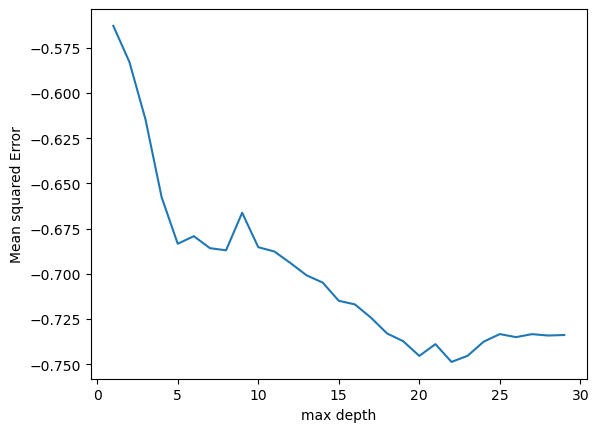

In [92]:
plt.plot(np.arange(1,30,1),grid.cv_results_['mean_test_score'])
plt.ylabel("Mean squared Error")
plt.xlabel("max depth")
plt.show()

### Plotting importance given to each feature in the model

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

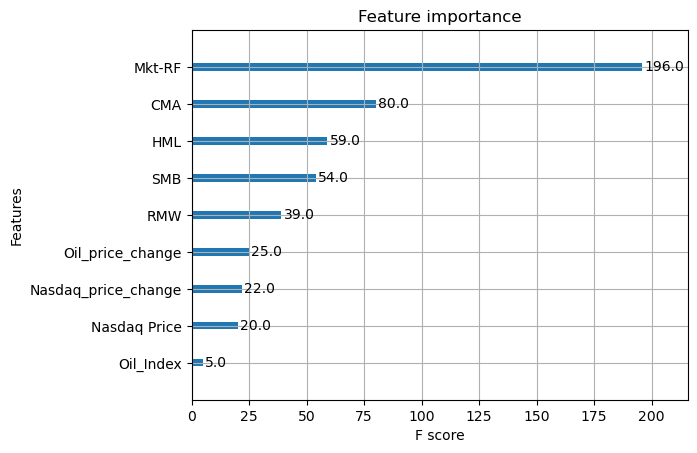

In [93]:
plot_importance(best_mse_model)

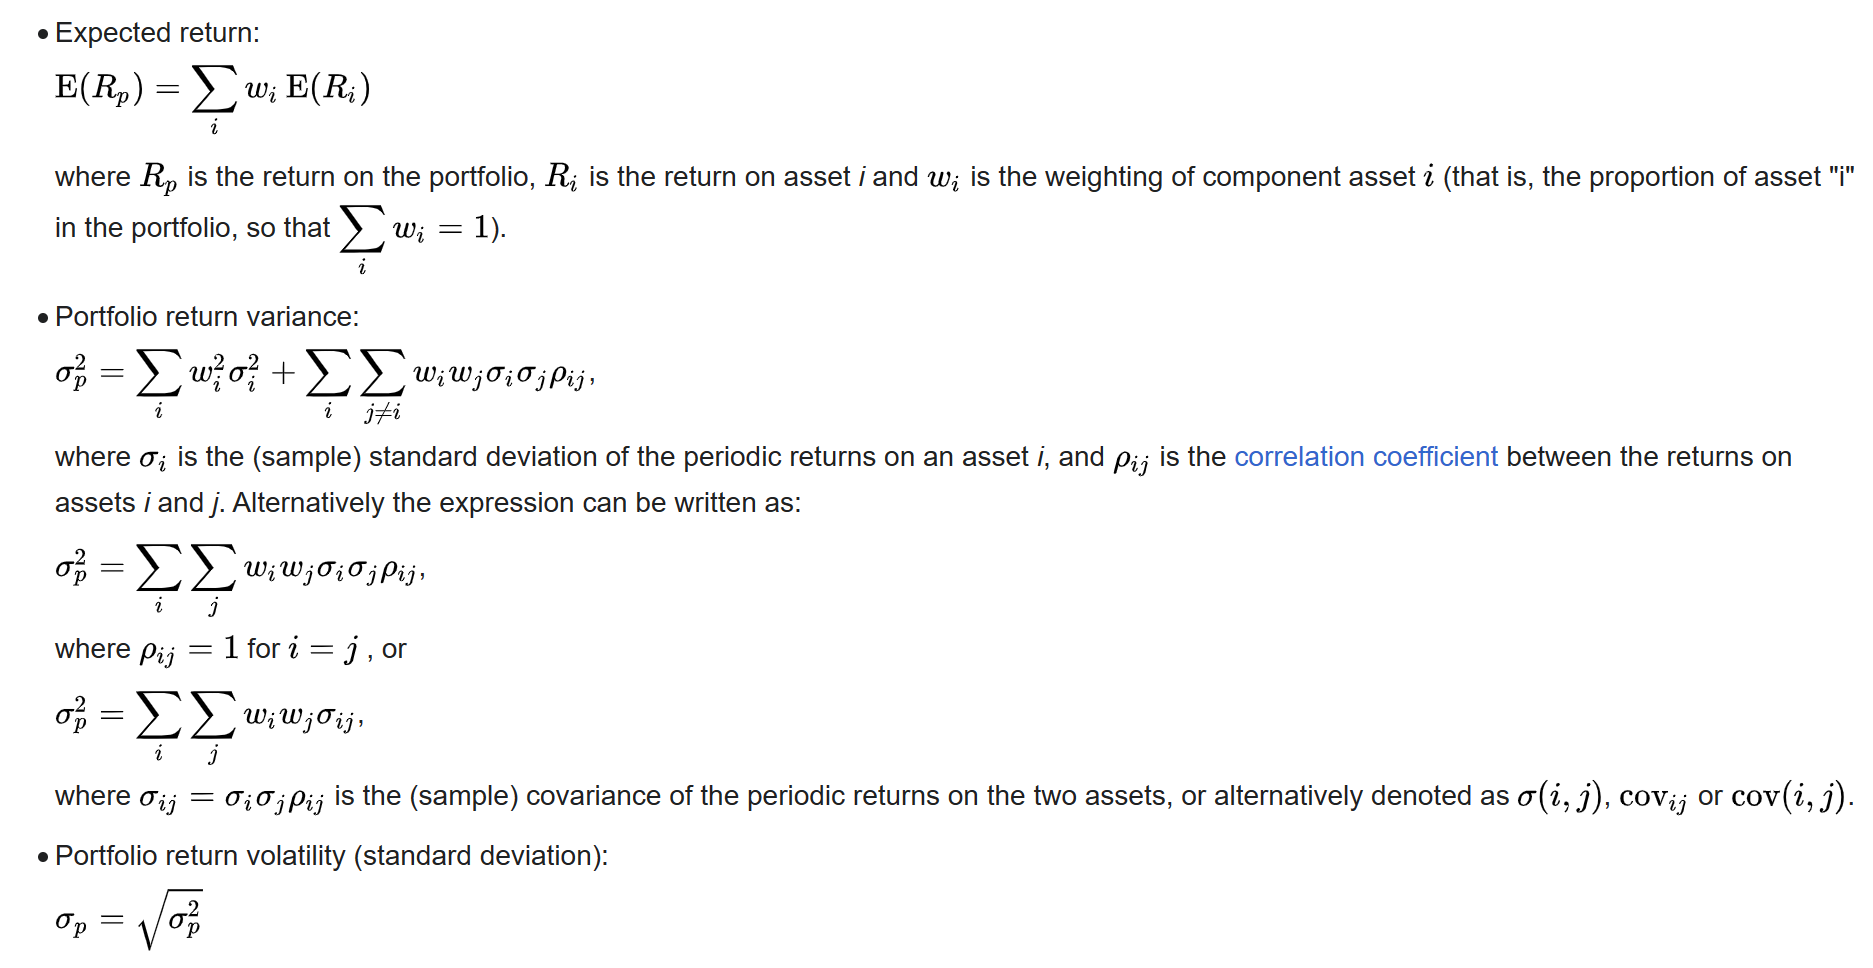

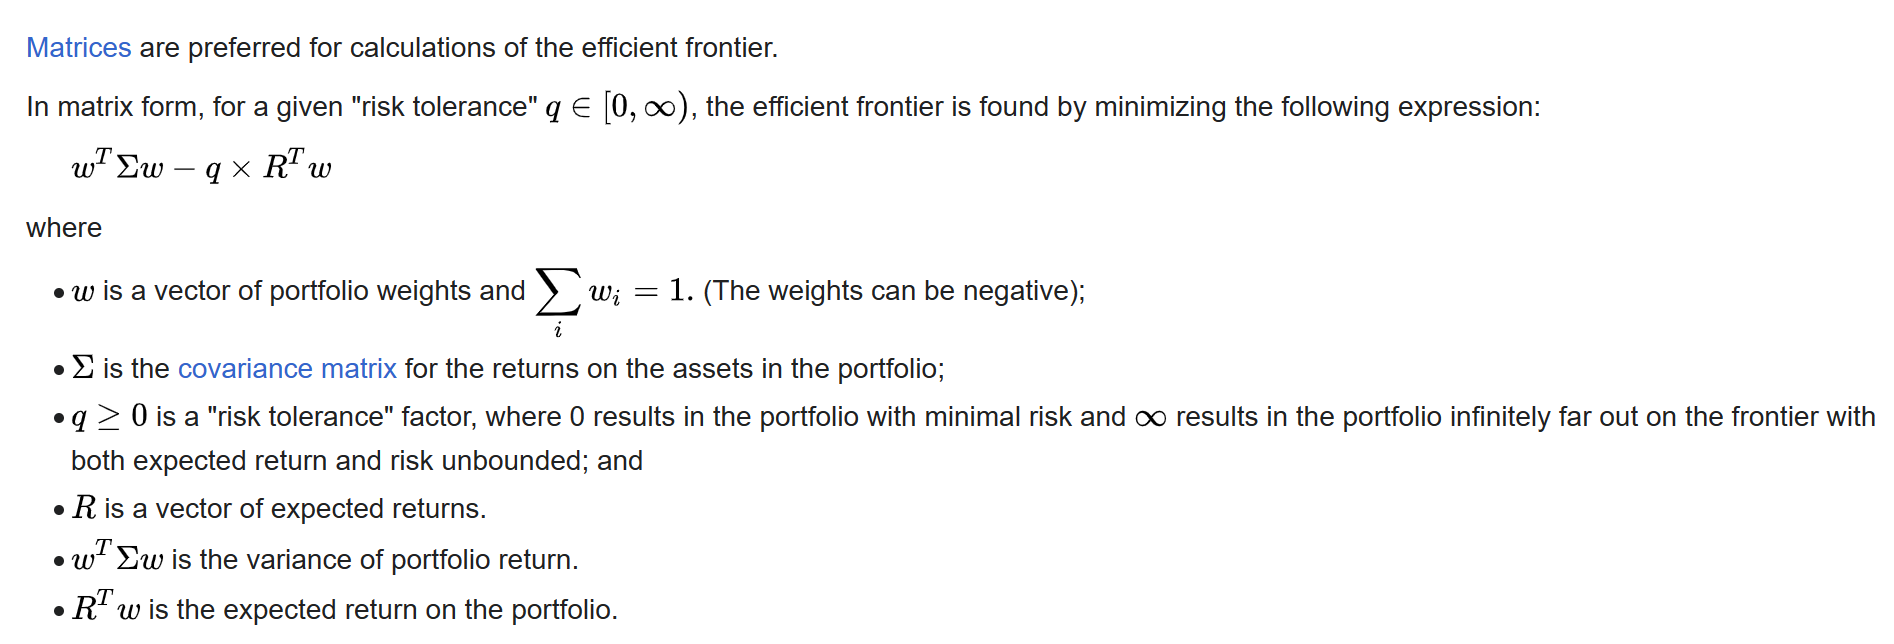

<span> q = num_assests and N-q is the number of helpful features </span>

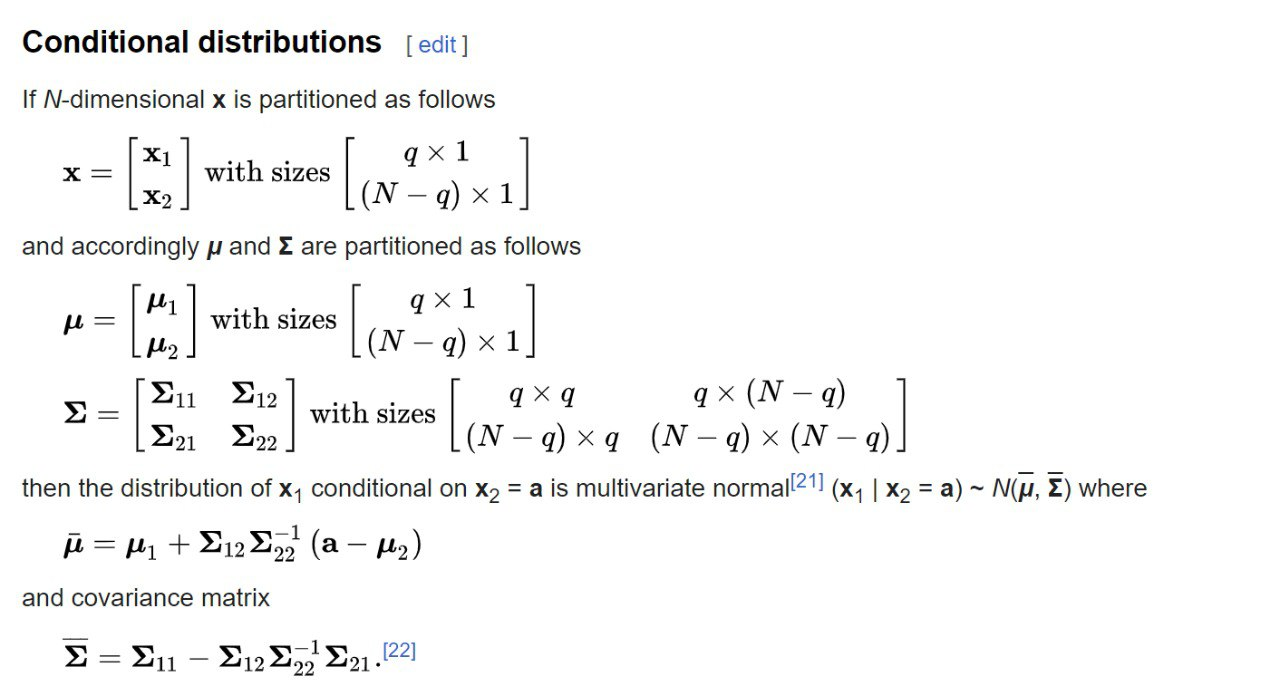

### Function to get the conditional covariance matrix 

In [94]:
def get_covariance_matrix(y_pred,helpful_X_data):
    xhat_yhat = np.concatenate([y_pred,helpful_X_data],axis=1).T # [q*N (N-q)*N]
    conditional_covariance = np.cov(xhat_yhat)
    # E11 - E12(E22^-1)E21
    E11 = conditional_covariance[:num_assests,:num_assests] # Err
    E12 = conditional_covariance[:num_assests,num_assests:] # Erx
    E21 = conditional_covariance[num_assests:,:num_assests] # Exr
    E22 = conditional_covariance[num_assests:,num_assests:] # Exx
    E22_inverse = np.linalg.inv(E22) 
    #assert E22_inverse.shape == (num_assests,num_assests), f"Shape of inverted matrix is: {E22_inverse.shape} instead of {(num_assests,num_assests)}"
    assert E12.shape[1] == E22_inverse.shape[0] & E22_inverse.shape[1] == E21.shape[0] # 5 * 5
    E_hat = E11 - np.dot(np.dot(E12,E22_inverse),E21) # E_hat must be (num_assests * num_assests) in shape
    assert E_hat.shape == (num_assests,num_assests)
    assert all(np.linalg.eigvalsh(E_hat)) == True # Test for Positive Semi-Definite matrix
    return E_hat


### Function to solve w^TEw - q*R^Tw to get the optimal portfolio distribution

In [95]:
def solve_markowitz(n,covariance_matrix,expected_return):
    # Weight vector
    w = cp.Variable(shape=(n,1))
    risk_tolerance = 0.1 # 10% risk tolerance
    # Objective function. Quad form is alias for :math:`x^T.P.x`. 
    obj = cp.quad_form(w,covariance_matrix) - risk_tolerance * cp.matmul(expected_return.T,w)
    # Constraints.
    constraints = [cp.sum(w) == 1, w >= 0, w <= 1]
    # Solve the optimization problem.
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve()
    # return the optimal portfolio weights
    return w.value

SAA Functions

In [1]:
def SAA(historical_data : pd.DataFrame,test_data,num_samples=10):
    # find the distribution of historical data 
    # using mean and standard deviation to predict the next step 
    historical_data = historical_data.pct_change().dropna()
    output_size = len(test_data)
    mean = historical_data.mean() # column vector with average price changes of each asset
    standard_deviation = historical_data.std() # column vector with std prices of each asset
    predictions = []
    for _ in range(num_samples):
        distribution = np.random.normal(loc=mean,scale=standard_deviation,size=output_size) # produce random price changes 
        price_changes = (test_data.values * (1 + distribution).cumprod(axis=0)).T
        predictions.append(price_changes)
    
    return np.mean(predictions,axis=0)

def Portfolio_SAA(historical_data:pd.DataFrame,test_data:pd.DataFrame):
    output = []
    n = len(historical_data)
    for asset in historical_data.columns:
        output.append(SAA(historical_data=historical_data[asset], test_data=test_data[asset]))
    output = np.array(output).T
    df_output = pd.DataFrame(data=output,columns=historical_data.columns,index=test_data.index)
    return df_output

NameError: name 'pd' is not defined

### Utility functions

In [97]:
# first row is 1s because that would be the starting point with 100% of the actual investment
def compounded_returns(pct_changes:pd.DataFrame,port_dist):
    temp = pct_changes.copy()+1
    temp.iloc[0] *= port_dist.ravel()
    for i in range(1,len(pct_changes)):
        temp.iloc[i] = temp.iloc[i]*temp.iloc[i-1]
    return temp

def get_profits(y_pred,X_test=X_test,investment_amount=100000):
    # given y_pred calculate covariance matrix and then the optimal weights
    # Find the profits achieved at the end of the out of sample data duration
    # find expected returns given helpful X information
    expected_returns = y_pred.mean(axis=0) # E(R|X) <--- confused about the calculation of expected returns
    optimal_weights = solve_markowitz(num_assests,get_covariance_matrix(y_pred,X_test),expected_returns)
    # test the optimized weights out of the optimised weights vector with out of sample data
    portfolio_distribution = optimal_weights * investment_amount
    # using out of sample data to calculate returns based on the portfolio distribution
    actual_returns = compounded_returns(out_of_sample_y,portfolio_distribution)
    return actual_returns.iloc[-1].sum() - investment_amount # profits earned at the end of the out of sample period

def convert_preds_to_price(data:pd.DataFrame,starting_price,scaler):
    inverted_data = pd.DataFrame(scaler.inverse_transform(data),columns=data.columns,index=data.index)
    data_copy = inverted_data.copy()
    data_copy += 1
    data_copy.iloc[0,:] = pd.Series(data_copy.iloc[0,:].values*starting_price)
    for i in range(1,len(data_copy)):
        data_copy.iloc[i,:] = pd.Series(data_copy.iloc[i-1,:].values*data_copy.iloc[i,:].values)
    return data_copy

def split_dataframe(data, block_size=21):
    blocks = []
    for start in range(0, len(data), block_size):
        end = start + block_size
        blocks.append(data.iloc[start:end])
    return blocks

def calc_returns(data:pd.DataFrame,starting_vector:pd.DataFrame,port_dist):
    # data must be price data
    df = pd.concat([starting_vector,data])
    df = df.pct_change().dropna()
    port_dist = port_dist.ravel()
    c_r = compounded_returns(df,port_dist)
    return c_r.iloc[-1].sum()

### Predictions on y_test data using best MSE model

In [98]:
preds = best_mse_model.predict(X_test)
preds = pd.DataFrame(data=preds,columns=[x+'_pred' for x in y_test.columns],index=X_test.index)
starting_vector = price_data[price_data.index == y_train.index[-1]].values[0]
predicted_price = convert_preds_to_price(preds,starting_vector,scaler)
y_test_converted = convert_preds_to_price(y_test,starting_vector,scaler)

C:\Users\saran\AppData\Local\Temp\ipykernel_1788\1575159289.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '135.68763620458776' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  data_copy.iloc[0,:] = pd.Series(data_copy.iloc[0,:].values*starting_price)
C:\Users\saran\AppData\Local\Temp\ipykernel_1788\1575159289.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '403.3222456653457' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  data_copy.iloc[0,:] = pd.Series(data_copy.iloc[0,:].values*starting_price)
C:\Users\saran\AppData\Local\Temp\ipykernel_1788\1575159289.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '573.03012249522' has dtype incompatible with float32, please explicitly ca

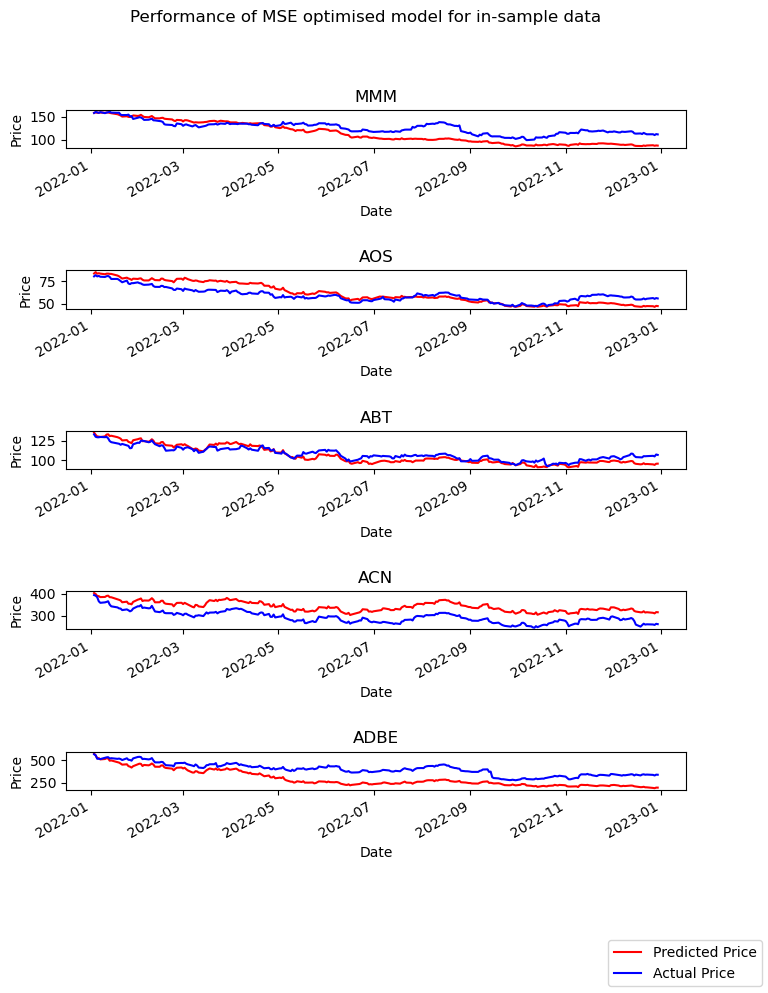

In [99]:
fig, axes = plt.subplots(num_assests, 1, figsize=(8, 10))

for i,col in enumerate(assests):
    predicted_price[col+'_pred'].plot(ax=axes[i], label='Pred_'+col,c='r')
    y_test_converted[col].plot(ax=axes[i], label='Actual_'+col,c='b')
    axes[i].set_title(col)
    axes[i].set_ylabel('Price')
    box = axes[i].get_position()
    axes[i].set_position([box.x0, box.y0, box.width, box.height * 2])
fig.suptitle("Performance of MSE optimised model for in-sample data")
fig.legend(['Predicted Price', 'Actual Price'],loc='lower right')
fig.subplots_adjust(hspace=3.2)
plt.show()

In [100]:
print('MSE: ', round(mean_squared_error(y_true=y_test,y_pred=preds),3))

MSE:  0.702


### Getting the best model based on the profits earned 

In [101]:
max_profits = -sys.maxsize
best_profits_model = None
profits_earned_per_model = []
for depth in range(1,30): # optimizing model depth 
    temp_model = XGBRegressor(max_depth=depth) # with other default parameters
    temp_model.fit(X_train,y_train)
    y_pred = pd.DataFrame(temp_model.predict(X_test),columns=y_test.columns,index=y_test.index)
    converted_y_pred = convert_preds_to_price(y_pred,starting_vector,scaler)
    expected_predicted = converted_y_pred.mean(axis=0)
    optimal_weights = solve_markowitz(num_assests,get_covariance_matrix(y_pred,X_test),expected_predicted)
    portfolio_distribution = optimal_weights*100000

    # compounded returns deals with percentage changes
    actual_returns = compounded_returns(pd.DataFrame(scaler.inverse_transform(y_pred)),portfolio_distribution)
    profits = actual_returns.iloc[-1].sum() - 100000

    profits_earned_per_model.append(profits)
    if profits > max_profits:
        max_profits = profits
        best_profits_model = temp_model


C:\Users\saran\AppData\Local\Temp\ipykernel_1788\1575159289.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '135.68763620458776' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  data_copy.iloc[0,:] = pd.Series(data_copy.iloc[0,:].values*starting_price)
C:\Users\saran\AppData\Local\Temp\ipykernel_1788\1575159289.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '403.3222456653457' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  data_copy.iloc[0,:] = pd.Series(data_copy.iloc[0,:].values*starting_price)
C:\Users\saran\AppData\Local\Temp\ipykernel_1788\1575159289.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '573.03012249522' has dtype incompatible with float32, please explicitly ca

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

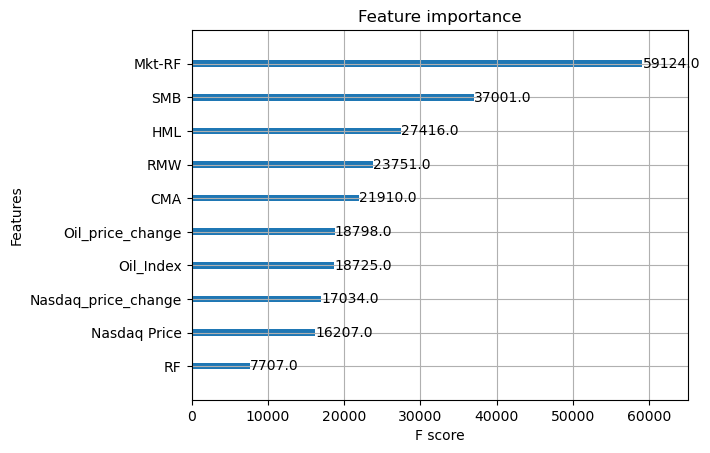

In [102]:
plot_importance(best_profits_model)

Text(0, 0.5, 'Expected returns')

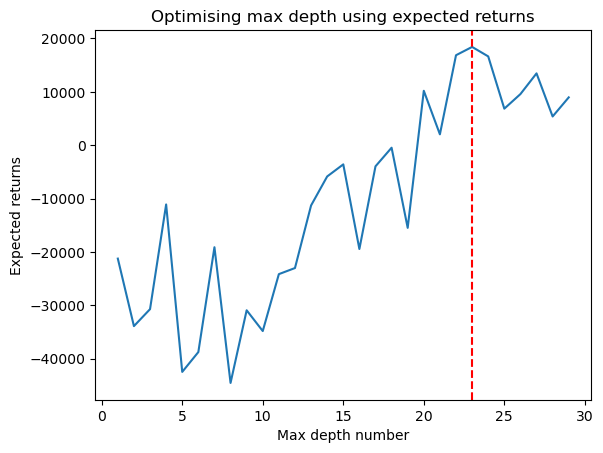

In [103]:
plt.plot(np.arange(1,30,1),profits_earned_per_model)
max_index = np.argmax(profits_earned_per_model)
plt.axvline(x=max_index + 1, color='r', linestyle='--', label=f'Maximum at {max_index + 1}')
plt.xlabel("Max depth number")
plt.title("Optimising max depth using expected returns")
plt.ylabel("Expected returns")

In [104]:
preds = convert_preds_to_price(pd.DataFrame(best_profits_model.predict(X_test)),starting_vector,scaler)
preds_2 = preds.copy()
preds_2.columns = [x+"_pred" for x in y_test.columns]
preds_2 = preds_2.set_index(y_test.index)

C:\Users\saran\AppData\Local\Temp\ipykernel_1788\1575159289.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '136.7026446689997' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  data_copy.iloc[0,:] = pd.Series(data_copy.iloc[0,:].values*starting_price)
C:\Users\saran\AppData\Local\Temp\ipykernel_1788\1575159289.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '402.84351161832456' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  data_copy.iloc[0,:] = pd.Series(data_copy.iloc[0,:].values*starting_price)
C:\Users\saran\AppData\Local\Temp\ipykernel_1788\1575159289.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '579.2833512876678' has dtype incompatible with float32, please explicitly 

In [105]:
mean_squared_error(y_true=y_test,y_pred=best_profits_model.predict(X_test))

0.9858287587213089

In [ ]:
# SAA data
price_train = price_data[(price_data.index >= TRAINING_START_DATE) & (price_data.index <= TRAINING_END_DATE)]
price_test = price_data[(price_data.index > TRAINING_END_DATE) & (price_data.index < OUT_OF_SAMPLE_START_DATE)]
price_out_of_sample = price_data[price_data.index >= OUT_OF_SAMPLE_START_DATE]

: 

In [ ]:
saa_price_predictions = SAA(price_train)

### Predictions using best profits model

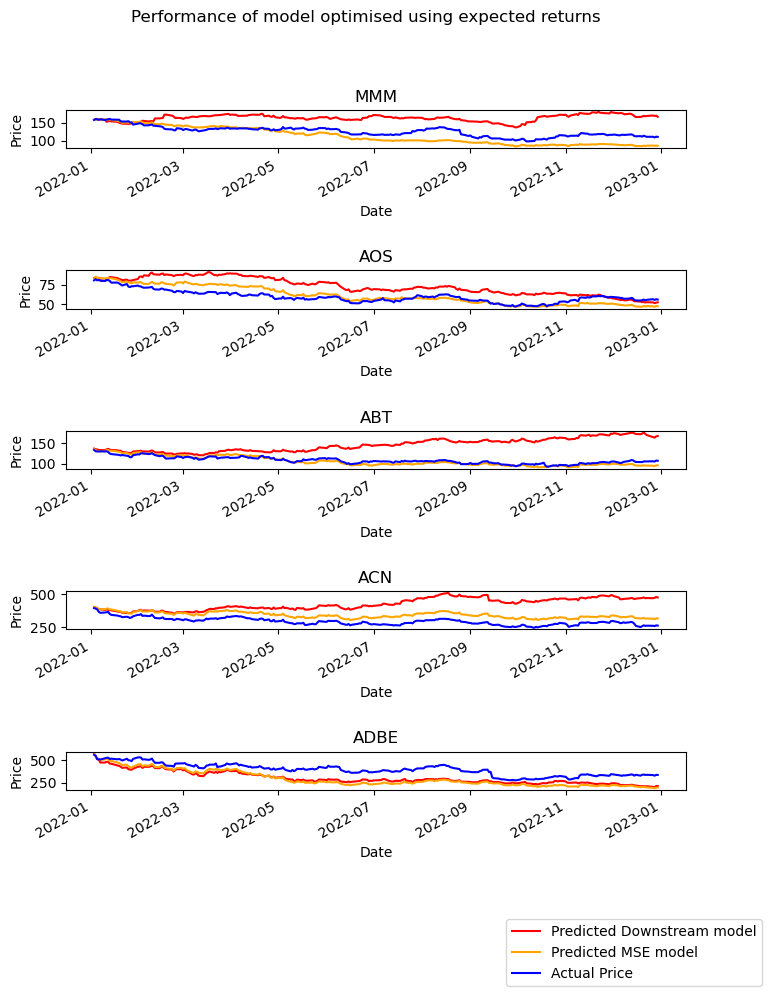

In [110]:
fig, axes = plt.subplots(2, 1,figsize=(8,10)) # TODO(Change 2 back to num_assests)
for i,col in enumerate(assests):
    preds_2[col+'_pred'].plot(ax=axes[i], label='Pred_'+col,c='r')
    predicted_price[col+'_pred'].plot(ax=axes[i], label='Pred_'+col,c='orange')
    y_test_converted[col].plot(ax=axes[i], label='Actual_'+col,c='b')
    axes[i].set_title(col)
    axes[i].set_ylabel('Price')
    

fig.suptitle("Performance of model optimised using expected returns")
fig.legend(['Predicted Downstream model','Predicted MSE model','Actual Price'],loc='lower right')
fig.subplots_adjust(hspace=3.2)
plt.show()

### Testing best MSE model against best Profits model on out of sample data

In [ ]:
time_period =  35 # (only works for large time periods)
initial_row = price_data[price_data.index==y_test.index[-1]]
out_of_sample_y_converted = convert_preds_to_price(out_of_sample_y,initial_row.values[0],scaler)
chunked_out_of_sample_y = split_dataframe(out_of_sample_y_converted,time_period)
chunked_out_of_sample_X = split_dataframe(out_of_sample_X,time_period)
profit_model_investment = 100
mse_model_investment = 100
mean_returns_best_mse_model = [mse_model_investment]
mean_returns_best_profit_model = [profit_model_investment]
for i,x_i in enumerate(chunked_out_of_sample_X):
    # Use the above conditional mean and covariance models to obtain the conditional mean and convariance given X = x1.
    # Use these values to solve the above Markowitz problem and get the portfolio weights w1. 
    starting_vector = initial_row if i == 0 else price_data[price_data.index == chunked_out_of_sample_X[i-1].index[-1]]
    yi_pred_mse_model = best_mse_model.predict(x_i)
    yi_pred_profit_model = best_profits_model.predict(x_i)

    # conditional mean
    mse_yi_mean = yi_pred_mse_model.mean(axis=0) # column wise mean calculation
    profit_yi_mean = yi_pred_profit_model.mean(axis=0)

    # conditional variance 
    mse_yi_var = get_covariance_matrix(yi_pred_mse_model,x_i)
    profit_yi_var = get_covariance_matrix(yi_pred_profit_model,x_i)
    
    # solve markowitz
    mse_optimal_weights = np.array(solve_markowitz(num_assests,mse_yi_var,mse_yi_mean)).reshape(5,1)
    profit_optimal_weights = np.array(solve_markowitz(num_assests,profit_yi_var,profit_yi_mean)).reshape(5,1)
    
    # use optimal weights to get returns from true y data
    mse_port_dist = mse_optimal_weights*mse_model_investment
    profit_port_dist = profit_optimal_weights*profit_model_investment
    true_y_data = chunked_out_of_sample_y[i] # in terms of price
    mse_returns = calc_returns(true_y_data,starting_vector,mse_port_dist)
    profit_returns = calc_returns(true_y_data,starting_vector,profit_port_dist)
    
    mse_model_investment = mse_returns + 100
    profit_model_investment = profit_returns + 100
    mean_returns_best_mse_model.append(mse_model_investment)
    mean_returns_best_profit_model.append(profit_model_investment)
    

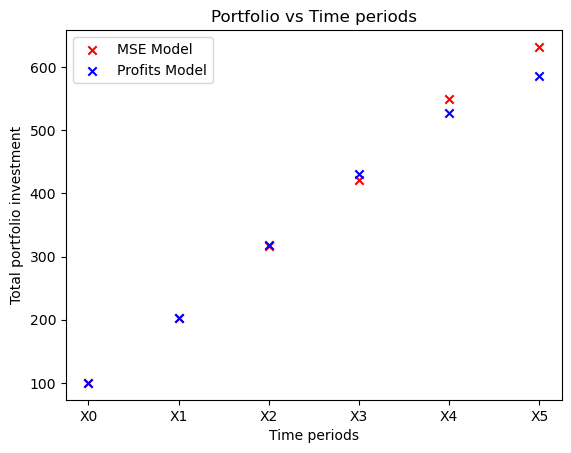

In [ ]:
x_arr = [f"X{i}" for i in range(len(mean_returns_best_profit_model))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_arr,mean_returns_best_mse_model,c='r',label='MSE Model',marker='x')
ax.scatter(x_arr,mean_returns_best_profit_model,c='b',label='Downstream decision Model',marker='x')
ax.set_ylabel("Total portfolio investment")
ax.set_xlabel("Time periods")
ax.set_title("Portfolio vs Time periods")
plt.legend()